In [5]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import anndata as an
import scanpy as sc 
from copy import deepcopy
from sklearn.metrics import silhouette_score
import pandas as pd 
from functions import spike_counts
import json
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor
from torch.optim.lr_scheduler import LambdaLR

Dataset Class

In [6]:
class EphysDataset(Dataset):
    def __init__(self,waveforms,spike_trains,normalize=True):
        self.waveforms = waveforms
        self.normalize = normalize
        self.spike_trains = spike_trains
    
    def __getitem__(self, idx):
        waveform = torch.as_tensor(self.waveforms[idx]).float()
        if self.normalize:
            waveform = waveform / torch.norm(waveform)
        waveform = waveform.unsqueeze(0)

        spike_train = torch.as_tensor(self.spike_trains[idx]).float()
        if self.normalize:
            spike_train = spike_train / torch.norm(spike_train)
        spike_train = spike_train.unsqueeze(0)
        return waveform, spike_train


    def __len__(self):
        return len(self.waveforms)

 Building on the traditional autoencoder framework, we train modality-specific encoders and decoders to map to and from this latent space such that the reconstructed training examples are similar to the original examples for all modalities.
 The modality-specific encoders and decoders used in this work were selected through Bayesian hyper-parameter optimization59. In particular, we used a base architecture of densely connected parallel convolutional blocks60,61 with 1d convolutional layers for ECGs and 2d convolutional layers for MRIs. For modality-specific modals, we optimized over the width, depth, activation functions, regularization and normalization strategies to achieve minimum reconstruction error for a given maximum overall capacity of 10 million parameters and a 256 dimensional latent space.  They used Contrastive Loss
 

In [7]:
class ConvAutoencoderMix(nn.Module):
    def __init__(self,intermediate_dim=32, latent_dim=16):
        super().__init__()
        
        self.encoder_wave = nn.Sequential(
            nn.Conv1d(1, intermediate_dim,3,padding=1),# in 1 channel, out intermediate_dim channels, kernel 3
            nn.ReLU(),
            nn.Conv1d(intermediate_dim, intermediate_dim, 3,padding=1), # in intermediate_dim channels, out intermediate_dim channels, kernel 3
            nn.ReLU(),
            nn.Conv1d(intermediate_dim, latent_dim, 3,padding=1), # in intermediate_dim channels, out intermediate_dim channels, kernel 3
        )
        
        self.decoder_wave = nn.Sequential(
            nn.ConvTranspose1d(intermediate_dim, intermediate_dim, 3, 3), 
            nn.ReLU(),
            nn.ConvTranspose1d(intermediate_dim, intermediate_dim, 3, 3),
            nn.ReLU(),
            nn.ConvTranspose1d(intermediate_dim, 1, 3, 3),
        )
        
        self.encoder_time = nn.Sequential(
            nn.Conv1d(1, intermediate_dim, 3,padding=1),# in 1 channel, out intermediate_dim channels, kernel 3
            nn.ReLU(),
            nn.Conv1d(intermediate_dim, intermediate_dim, 3,padding=1), # in intermediate_dim channels, out intermediate_dim channels, kernel 3
            nn.ReLU(),
            nn.Conv1d(intermediate_dim, latent_dim, 3,padding=1), # in intermediate_dim channels, out intermediate_dim channels, kernel 3
        )
        
        self.decoder_time = nn.Sequential(
            nn.ConvTranspose1d(latent_dim, intermediate_dim, 5, 3), 
            nn.ReLU(),
            nn.ConvTranspose1d(intermediate_dim, intermediate_dim, 4, 3),
            nn.ReLU(),
            nn.ConvTranspose1d(intermediate_dim, 1, 5, 3),
        )

        self.norm = nn.AdaptiveAvgPool1d(1)

    def forward(self, wave, time):
        wave_size = wave.size(1)
        time_size = time.size(1)
        print("Input",wave_size, time_size)
        print("Before encoding",wave.size(), time.size())
        rep_w, rep_t = self.encoder_wave(wave), self.encoder_time(time)
        
        print("After encoding",rep_w.size(), rep_t.size())
        rep_w = self.norm(rep_w)
        rep_t = self.norm(rep_t)
        print("After pooling",rep_w.size(), rep_t.size())

        rep_w = rep_w.unsqueeze(0).expand(-1,-1,wave_size)
        rep_t = rep_t.unsqueeze(0).expand(-1,-1,time_size)
        print("After expanding",rep_w.size(), rep_t.size())

        decode_w, decode_t = self.decoder_wave(rep_w), self.decoder_time(rep_t)
        print(rep_w.size(), rep_t.size(), decode_w.size(), decode_t.size())

        decode_w, decode_t = F.interpolate(decode_w, (wave.size(-1),)), F.interpolate(decode_t, (time.size(-1),))
        return rep_w, rep_t, decode_w, decode_t
    
# autoencoder = ConvAutoencoderMix()
# test_input = torch.rand(1,50)#.unsqueeze(0)
# test_input2 = torch.rand(1,500)#.unsqueeze(0)
# print('Spike Times',test_input.size())
# print('Waveform',test_input2.size())
# output = autoencoder(test_input,test_input2)#,test_input2)
# print("output",output[0].size(),output[1].size(),output[2].size(),output[3].size())

In [8]:
class ConvAutoencoder(nn.Module):
    def __init__(self, intermediate_dim=16, waveform_dim=50, time_dim=500):
        super().__init__()
        self.intermediate_dim = intermediate_dim
        self.encoder = nn.Sequential(
            nn.Conv1d(1, intermediate_dim, 3),# in 1 channel, out intermediate_dim channels, kernel 3
            nn.ReLU(),
            nn.Conv1d(intermediate_dim, intermediate_dim, 3), # in intermediate_dim channels, out intermediate_dim channels, kernel 3
            nn.ReLU(),
            nn.Conv1d(intermediate_dim, intermediate_dim, 3), # in intermediate_dim channels, out intermediate_dim channels, kernel 3
        )
        
        self.fc_wave = nn.Linear(intermediate_dim*(waveform_dim-6), intermediate_dim*2) #In intermediate_dim channels by 50-6, out 32
        self.fc_time = nn.Linear(intermediate_dim*(time_dim-6), intermediate_dim*2) #In intermediate_dim channels by 500-6, out 32
        self.norm = nn.BatchNorm1d(intermediate_dim) #Normalize the 32 channels into a 1D vector I think.
        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(intermediate_dim, intermediate_dim, 5, 3), 
            nn.ReLU(),
            nn.ConvTranspose1d(intermediate_dim, intermediate_dim, 4, 3),
            nn.ReLU(),
            nn.ConvTranspose1d(intermediate_dim, 1, 5, 3),
        )
        
    def forward(self, wave, time):
        B = wave.size(0)
        #print("B",B)
        #print("Before encoding",wave.size(), time.size())
        rep_w, rep_t = self.encoder(wave), self.encoder(time)
        #print("After encoding",rep_w.size(), rep_t.size())
        rep_w, rep_t = rep_w.view(B, -1), rep_t.view(B, -1)
        #print("After reshaping",rep_w.size(), rep_t.size())
        rep_w = self.fc_wave(rep_w)
        rep_t = self.fc_time(rep_t)
        #print("After FC",rep_w.size(), rep_t.size())
        decode_w, decode_t = self.decoder(rep_w.view(B, self.intermediate_dim, -1)), self.decoder(rep_t.view(B, self.intermediate_dim, -1))
        #print(rep_w.size(), rep_t.size(), decode_w.size(), decode_t.size())

        decode_w, decode_t = F.interpolate(decode_w, (wave.size(-1),)), F.interpolate(decode_t, (time.size(-1),))
        decode_w,decode_t = decode_w.squeeze(1), decode_t.squeeze(1)
        return rep_w, rep_t, decode_w, decode_t 
    

test_input = torch.rand(1,50)#.unsqueeze(0)
test_input2 = torch.rand(1,600)#.unsqueeze(0)
autoencoder = ConvAutoencoder(intermediate_dim=16, waveform_dim=test_input.size(-1), time_dim=test_input2.size(-1))
print('Spike Times',test_input.size())
print('Waveform',test_input2.size())
output = autoencoder(test_input,test_input2)#,test_input2)
print("output",output[0].size(),output[1].size(),output[2].size(),output[3].size())

Spike Times torch.Size([1, 50])
Waveform torch.Size([1, 600])
output torch.Size([1, 32]) torch.Size([1, 32]) torch.Size([1, 50]) torch.Size([1, 600])


For the error it was a mixture of reconstruction error and Loss

In [9]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5,lambda_param=0.1):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)
        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        #print("similarity_matrix",similarity_matrix)
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        #print("sim_ij",sim_ij.size())
        #print("sim_ji",sim_ji.size())
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        #print("positives",positives)
        #print("positives",positives.size())
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
        #print("denominator",denominator)
        #print("denominator",denominator.size())
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss
    
# loss = ContrastiveReconstructionLoss(temperature=0.5)
loss = ContrastiveLoss(batch_size=10, temperature=0.5)

# #Batch embedding 
# embeddings_i = torch.rand(10, 6,requires_grad=True)#Dataloader does it automatically 
# print("embeddings_i",embeddings_i.size())
# print("embeddings_i",embeddings_i)
# embeddings_j = torch.rand(10, 6,requires_grad=True)
# print("embeddings_j",embeddings_j.size())
# output = loss(embeddings_i, embeddings_j)
# print("output",output)
# output.backward()

In [10]:
class ReconstructionLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input_wf,input_st,output_wf,output_st):
        input_wf = input_wf.squeeze(1) #Remove the channel dimension
        input_st = input_st.squeeze(1) #Remove the channel dimension
        loss_wf = F.mse_loss(input_wf, output_wf, reduction='mean')
        loss_st = F.mse_loss(input_st, output_st, reduction='mean')
        return loss_wf + loss_st

In [11]:
from typing import Any
import lightning.pytorch as pl
from lightning.pytorch.utilities import grad_norm


class ConvAutoEncoderWrapper(pl.LightningModule):
    def __init__(self, intermediate_dim=16, waveform_dim=50, time_dim=500 ,batch_size=10):
        super(ConvAutoEncoderWrapper, self).__init__()
        self.model = ConvAutoencoder(intermediate_dim, waveform_dim=waveform_dim, time_dim=time_dim) #Define the model
        self.loss_fn_contrastive = ContrastiveLoss(batch_size=batch_size, temperature=0.2) #Define the loss function
        self.loss_fn_reconstruction = ReconstructionLoss() #Define the loss function
        self.loss = [] #Store the loss
        for param in self.model.parameters(): #Set the model to trainable, usually not necessary
            param.requires_grad = True

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4,weight_decay=1e-3) #Define the optimizer
        scheduler = self.get_lr_scheduler(optimizer, warmup_steps=50, lr=1e-4, epsilon=1e-8) #Define the learning rate scheduler
        return {"optimizer": optimizer, "lr_scheduler": scheduler} #Return the optimizer and the scheduler
    


    def forward(self, x_i, x_j):
        return self.model(x_i, x_j) #Forward pass

    def training_step(self, batch, batch_idx):
        self.model.train() #Set the model to training mode
        x_i, x_j = batch #Get the batch
        h_i, h_j, z_i, z_j = self.forward(x_i, x_j) #Forward pass
        contrastive_loss = self.loss_fn_contrastive(h_i, h_j) #Compute the loss
        reconstruction_loss = self.loss_fn_reconstruction(x_i, x_j, z_i, z_j)

        loss = contrastive_loss + reconstruction_loss #In the paper they describe a weighted sum of both losses
        self.log('train_loss', loss) #Log the loss
        self.log('train_contrastive_loss', contrastive_loss) #Log the contrastive loss
        self.log('train_reconstruction_loss', reconstruction_loss)
        self.loss.append(loss.item()) #Store the loss
        #if batch_idx == 0:
        #print(f"Batch {batch_idx} Loss {loss.item()}")
        return loss
    
    def on_train_epoch_end(self) -> None:
        print(f"Epoch {self.current_epoch} Loss {np.mean(self.loss)}") #Print the loss
        self.loss = [] #Reset the loss
        return super().on_train_epoch_end()
    
    def validation_step(self, batch,batch_idx):
        x_i, x_j = batch #Get the batch
        h_i, h_j, z_i, z_j = self.forward(x_i, x_j) #Forward pass
        contrastive_loss = self.loss_fn_contrastive(h_i, h_j) #Compute the loss
        reconstruction_loss = self.loss_fn_reconstruction(x_i, x_j, z_i, z_j)
        loss = contrastive_loss + reconstruction_loss #In the paper they describe a weighted sum of both losses
        self.log('validation_loss', loss) #Log the validation loss
        self.log('val_contrastive_loss', contrastive_loss) #Log the contrastive loss
        self.log('val_reconstruction_loss', reconstruction_loss)
        return loss
    
    @staticmethod
    def get_lr_scheduler(optimizer, warmup_steps, lr, epsilon):
        def lr_lambda(current_step):
            if current_step < warmup_steps:
                return (lr - epsilon) / warmup_steps * current_step + epsilon
            else:
                return lr  # Use the initial learning rate after warm-up
        scheduler = LambdaLR(optimizer, lr_lambda)
        return scheduler

    
    def get_encoder_embeddings(self, batch):
        x_i, x_j = batch #Get the batch
        h_i, h_j, z_i, z_j = self.forward(x_i, x_j) #Forward pass for encoder only.
        return h_i, h_j
    
    def get_waveform_embeddings(self, batch):
        
        x_i, x_j = batch
        h_i, h_j, z_i, z_j = self.forward(x_i, x_j)
        return h_i
    
    def get_spike_train_embeddings(self, batch):
        x_i, x_j = batch
        h_i, h_j, z_i, z_j = self.forward(x_i, x_j)
        return h_j

    def get_mixed_embeddings(self, batch):
        x_i, x_j = batch
        h_i, h_j, z_i, z_j = self.forward(x_i, x_j)
        embed = h_j + h_j
        embed = embed / 2
        return embed
    def get_waveform_reconstruction(self, batch):
        x_i, x_j = batch
        h_i, h_j, z_i, z_j = self.forward(x_i, x_j)
        return x_i,z_i
    def get_spike_train_reconstruction(self, batch):
        x_i, x_j = batch
        h_i, h_j, z_i, z_j = self.forward(x_i, x_j)
        return x_j,z_j

    def on_before_optimizer_step(self, optimizer):
        # Compute the 2-norm for each layer
        # If using mixed precision, the gradients are already unscaled here
        norms = grad_norm(self.model.encoder[0], norm_type=2)
        self.log_dict(norms)

To ensure that only one modality is needed at test time, we additionally utilized dropout to merge modality-specific embeddings. In particular, during training, we employed dropout of a random subset of coordinates of the ECG embedding and merged it with the complementary coordinates from the MRI embedding.

From here everything is testing

In [22]:
waveforms = np.load("/Users/jesusgf/Desktop/mouse_electrophys/ephys_learning/data/chip19894_cut.npy")

waveforms_train = waveforms[0:3500, :]
waveforms_val = waveforms[3500:, :]


# Specify the file path
file_path = '/Users/jesusgf/Desktop/mouse_electrophys/ephys_learning/data/chip19894_info.json'

# Load the JSON file
with open(file_path, 'r') as f:
    info = json.load(f)

spike_trains = [data["train"] for data in info.values()]
position = [data["location"] for data in info.values()]

spike_processed = ([spike_counts(spike_train, 1) for spike_train in spike_trains])#, dtype=object)
print(max(len(spike) for spike in spike_processed))
#Pad the spike trains to the maximum length
spike_processed = [np.pad(arr, (0, max(0, 600 - len(arr))), mode='constant')[:600] for arr in spike_processed]

spike_times_train = spike_processed[0:3500]
spike_times_val = spike_processed[3500:]

dataset_train = EphysDataset(waveforms_train, spike_times_train)
dataset_val = EphysDataset(waveforms_val, spike_times_val)
print("dataset_train",dataset_train[0][0].size(),dataset_train[0][1].size())
print("dataset_val",dataset_val[0][0].size(),dataset_val[0][1].size())
batch_size = 256
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,drop_last=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False,drop_last=True)
next(iter(dataloader_train))[0].size(),next(iter(dataloader_train))[1].size()
next(iter(dataloader_val))[0].size(),next(iter(dataloader_val))[1].size()

602
dataset_train torch.Size([1, 50]) torch.Size([1, 600])
dataset_val torch.Size([1, 50]) torch.Size([1, 600])


(torch.Size([256, 1, 50]), torch.Size([256, 1, 600]))

In [13]:
next(iter(dataloader_train))[0].size(-1),next(iter(dataloader_train))[1].size(-1)

(50, 600)

In [14]:
wrapper = ConvAutoEncoderWrapper(intermediate_dim=16, waveform_dim=next(iter(dataloader_train))[0].size(-1), time_dim=next(iter(dataloader_train))[1].size(-1), batch_size=batch_size)

In [15]:
wandb_logger = WandbLogger(log_model="all",project="ephys_deep_learning")
trainer = pl.Trainer(max_epochs=1000,accelerator='cpu',devices=1,logger=wandb_logger, callbacks=[LearningRateMonitor(logging_interval='step')])
trainer.fit(wrapper, dataloader_train, dataloader_val)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jesusgf1 (mostajo-group). Use `wandb login --relogin` to force relogin



  | Name                   | Type               | Params
--------------------------------------------------------------
0 | model                  | ConvAutoencoder    | 330 K 
1 | loss_fn_contrastive    | ContrastiveLoss    | 0     
2 | loss_fn_reconstruction | ReconstructionLoss | 0     
--------------------------------------------------------------
330 K     Trainable params
0         Non-trainable params
330 K     Total params
1.323     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0 Loss 10.97339446728046


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 Loss 10.973842254051796


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 Loss 10.973104110130897


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 Loss 10.97286451779879


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 Loss 10.972278448251577


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 Loss 10.971307240999662


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 Loss 10.970777218158428


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 Loss 10.969698098989634


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 Loss 10.968327375558706


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 Loss 10.966694024892954


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 Loss 10.965264613811787


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 Loss 10.963373991159292


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 Loss 10.961709829477163


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 Loss 10.959317500774677


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 Loss 10.957235483022837


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 Loss 10.954556024991549


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 Loss 10.95191610776461


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 Loss 10.949105409475473


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 Loss 10.946397267855131


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 Loss 10.942979959341196


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20 Loss 10.940144392160269


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21 Loss 10.936529966501089


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22 Loss 10.932966819176308


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23 Loss 10.928813787607046


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24 Loss 10.92460008767935


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25 Loss 10.920707702636719


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26 Loss 10.91637633397029


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27 Loss 10.911678901085487


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28 Loss 10.907675669743465


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29 Loss 10.902704018812914


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30 Loss 10.897674047029936


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31 Loss 10.892481803894043


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32 Loss 10.887189791752743


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33 Loss 10.881635445814867


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34 Loss 10.876328248244066


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35 Loss 10.870060920715332


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36 Loss 10.864250696622408


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37 Loss 10.857871789198656


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38 Loss 10.851655153127817


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39 Loss 10.845240739675669


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40 Loss 10.838820530818058


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41 Loss 10.831961925213154


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42 Loss 10.824722363398624


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43 Loss 10.817981426532452


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44 Loss 10.810347190270058


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45 Loss 10.803035149207481


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46 Loss 10.795463488652157


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47 Loss 10.787471037644606


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48 Loss 10.779280735896183


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49 Loss 10.771112442016602


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 50 Loss 10.763057488661547


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 51 Loss 10.754716359652006


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 52 Loss 10.746079444885254


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 53 Loss 10.738109441903921


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 54 Loss 10.729137273935171


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 55 Loss 10.72089510697585


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 56 Loss 10.712309763981747


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 57 Loss 10.704012137192946


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 58 Loss 10.69570937523475


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 59 Loss 10.68704135601337


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 60 Loss 10.678841737600473


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 61 Loss 10.670190884516789


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 62 Loss 10.662102772639347


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 63 Loss 10.653297571035532


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 64 Loss 10.645179821894718


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 65 Loss 10.636565942030687


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 66 Loss 10.628188646756685


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 67 Loss 10.619755231417143


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 68 Loss 10.611392974853516


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 69 Loss 10.602926547710712


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 70 Loss 10.59512028327355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 71 Loss 10.58621149796706


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 72 Loss 10.577870955834022


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 73 Loss 10.569573329045223


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 74 Loss 10.561133164625902


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 75 Loss 10.55273650242732


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 76 Loss 10.544123136080229


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 77 Loss 10.5361296580388


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 78 Loss 10.527438530555138


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 79 Loss 10.519340221698467


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 80 Loss 10.51084643143874


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 81 Loss 10.502513371981108


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 82 Loss 10.494309498713566


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 83 Loss 10.486007690429688


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 84 Loss 10.477568186246431


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 85 Loss 10.468956360450157


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 86 Loss 10.460813522338867


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 87 Loss 10.45234672839825


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 88 Loss 10.444188044621395


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 89 Loss 10.435880734370304


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 90 Loss 10.427402643057016


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 91 Loss 10.419173460740309


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 92 Loss 10.4106293458205


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 93 Loss 10.402407792898325


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 94 Loss 10.393806457519531


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 95 Loss 10.385952436006987


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 96 Loss 10.377358289865347


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 97 Loss 10.368851368243877


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 98 Loss 10.360664441035343


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 99 Loss 10.352447729844313


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 100 Loss 10.344201161311222


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 101 Loss 10.335810514596792


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 102 Loss 10.327322593102089


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 103 Loss 10.319329848656288


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 104 Loss 10.310833564171425


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 105 Loss 10.302621841430664


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 106 Loss 10.294129665081318


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 107 Loss 10.286258917588453


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 108 Loss 10.277317633995644


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 109 Loss 10.269490242004395


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 110 Loss 10.26111287337083


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 111 Loss 10.25252943772536


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 112 Loss 10.244324977581318


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 113 Loss 10.236074080834022


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 114 Loss 10.227535027724047


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 115 Loss 10.219501055203951


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 116 Loss 10.211058469919058


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 117 Loss 10.203006524306078


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 118 Loss 10.194637225224422


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 119 Loss 10.186030974754921


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 120 Loss 10.177922542278584


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 121 Loss 10.16955852508545


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 122 Loss 10.161478776198168


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 123 Loss 10.152989607590895


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 124 Loss 10.144996202909029


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 125 Loss 10.136341681847206


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 126 Loss 10.127702126136192


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 127 Loss 10.119647392859825


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 128 Loss 10.111588698167067


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 129 Loss 10.103348878713755


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 130 Loss 10.09502726334792


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 131 Loss 10.087095480698805


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 132 Loss 10.078316908616285


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 133 Loss 10.07020928309514


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 134 Loss 10.06217252291166


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 135 Loss 10.053906587453989


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 136 Loss 10.045440527109


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 137 Loss 10.037041737483097


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 138 Loss 10.028856350825382


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 139 Loss 10.020653357872597


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 140 Loss 10.011930539057804


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 141 Loss 10.004264464745155


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 142 Loss 9.99611025590163


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 143 Loss 9.987606928898739


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 144 Loss 9.979480890127329


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 145 Loss 9.9713925581712


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 146 Loss 9.962936254648062


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 147 Loss 9.95456049992488


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 148 Loss 9.946715574998121


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 149 Loss 9.938264039846567


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 150 Loss 9.930434887225811


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 151 Loss 9.92166673220121


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 152 Loss 9.914115245525654


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 153 Loss 9.90542221069336


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 154 Loss 9.897993381206806


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 155 Loss 9.888878308809721


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 156 Loss 9.881204825181227


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 157 Loss 9.873083921579214


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 158 Loss 9.864816665649414


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 159 Loss 9.856302041273851


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 160 Loss 9.848355880150429


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 161 Loss 9.839978218078613


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 162 Loss 9.832177235529972


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 163 Loss 9.823690487788273


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 164 Loss 9.815709554232084


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 165 Loss 9.807828536400429


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 166 Loss 9.799592458284819


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 167 Loss 9.791265634390024


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 168 Loss 9.782831998971792


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 169 Loss 9.775212434621958


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 170 Loss 9.767091824458195


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 171 Loss 9.759065261253944


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 172 Loss 9.75041836958665


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 173 Loss 9.742710186884953


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 174 Loss 9.734751114478478


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 175 Loss 9.726212428166317


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 176 Loss 9.71817552126371


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 177 Loss 9.71008880321796


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 178 Loss 9.70177987905649


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 179 Loss 9.693672473614033


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 180 Loss 9.685826961810772


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 181 Loss 9.678117898794321


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 182 Loss 9.669926276573769


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 183 Loss 9.661923701946552


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 184 Loss 9.654113476092999


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 185 Loss 9.645731925964355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 186 Loss 9.637814815227802


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 187 Loss 9.630144192622257


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 188 Loss 9.621737186725323


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 189 Loss 9.61393613081712


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 190 Loss 9.605616129361666


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 191 Loss 9.59759572836069


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 192 Loss 9.589602030240572


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 193 Loss 9.581728788522573


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 194 Loss 9.573867064255934


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 195 Loss 9.565806168776293


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 196 Loss 9.55771328852727


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 197 Loss 9.549757884098934


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 198 Loss 9.54184047992413


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 199 Loss 9.53438744178185


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 200 Loss 9.525945883530836


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 201 Loss 9.517993120046762


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 202 Loss 9.510377957270695


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 203 Loss 9.5023073049692


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 204 Loss 9.494044083815355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 205 Loss 9.486638876108023


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 206 Loss 9.478127186114971


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 207 Loss 9.47005770756648


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 208 Loss 9.463005212637094


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 209 Loss 9.454583388108473


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 210 Loss 9.446979009188139


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 211 Loss 9.438948924724873


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 212 Loss 9.431176332327036


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 213 Loss 9.423342337975136


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 214 Loss 9.415155190687914


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 215 Loss 9.40755477318397


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 216 Loss 9.399636635413536


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 217 Loss 9.392071650578426


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 218 Loss 9.383908711946928


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 219 Loss 9.37630007817195


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 220 Loss 9.368285839374249


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 221 Loss 9.360312315133902


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 222 Loss 9.35276904472938


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 223 Loss 9.344924193162184


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 224 Loss 9.337203319256123


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 225 Loss 9.329404170696552


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 226 Loss 9.321452360886793


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 227 Loss 9.31402140397292


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 228 Loss 9.306084119356596


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 229 Loss 9.29814551426814


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 230 Loss 9.290651981647198


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 231 Loss 9.282781600952148


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 232 Loss 9.274987147404598


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 233 Loss 9.267087642963116


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 234 Loss 9.259456047644981


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 235 Loss 9.25216506077693


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 236 Loss 9.244171729454628


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 237 Loss 9.236465967618502


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 238 Loss 9.22888264289269


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 239 Loss 9.221033316392164


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 240 Loss 9.213328581589918


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 241 Loss 9.205539776728703


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 242 Loss 9.198011545034555


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 243 Loss 9.190378922682543


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 244 Loss 9.1827361033513


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 245 Loss 9.175103407639723


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 246 Loss 9.167449144216684


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 247 Loss 9.159484423123873


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 248 Loss 9.152186760535606


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 249 Loss 9.144425318791317


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 250 Loss 9.137033389164852


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 251 Loss 9.129386094900278


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 252 Loss 9.121929608858549


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 253 Loss 9.114109626183144


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 254 Loss 9.106421103844276


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 255 Loss 9.09896703866812


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 256 Loss 9.091416358947754


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 257 Loss 9.083646114055927


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 258 Loss 9.076353733356182


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 259 Loss 9.068746933570274


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 260 Loss 9.060948591965895


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 261 Loss 9.053494380070614


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 262 Loss 9.045985955458422


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 263 Loss 9.03805688711313


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 264 Loss 9.030903816223145


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 265 Loss 9.02393047626202


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 266 Loss 9.015824317932129


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 267 Loss 9.008570524362417


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 268 Loss 9.000883762653057


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 269 Loss 8.993567393376278


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 270 Loss 8.98614369905912


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 271 Loss 8.978382844191332


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 272 Loss 8.97112516256479


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 273 Loss 8.963467891399677


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 274 Loss 8.956045444195087


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 275 Loss 8.948624244103065


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 276 Loss 8.94131249647874


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 277 Loss 8.9337126658513


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 278 Loss 8.926228229816143


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 279 Loss 8.91887877537654


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 280 Loss 8.911183503957895


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 281 Loss 8.904034981360802


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 282 Loss 8.896368026733398


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 283 Loss 8.88904622884897


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 284 Loss 8.88151557628925


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 285 Loss 8.874418552105244


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 286 Loss 8.867017892690805


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 287 Loss 8.859329517071064


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 288 Loss 8.852274014399601


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 289 Loss 8.845106858473558


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 290 Loss 8.837438803452711


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 291 Loss 8.8299560546875


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 292 Loss 8.82278273655818


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 293 Loss 8.815495124230019


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 294 Loss 8.808234288142277


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 295 Loss 8.800775821392353


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 296 Loss 8.793790890620304


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 297 Loss 8.786243512080265


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 298 Loss 8.778814022357647


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 299 Loss 8.771111488342285


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 300 Loss 8.764389771681566


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 301 Loss 8.7571047269381


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 302 Loss 8.750047243558443


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 303 Loss 8.742374126727764


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 304 Loss 8.735456540034367


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 305 Loss 8.728152421804575


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 306 Loss 8.721022752615122


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 307 Loss 8.714061003464918


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 308 Loss 8.70647694514348


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 309 Loss 8.699400388277494


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 310 Loss 8.692067586458647


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 311 Loss 8.685170100285458


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 312 Loss 8.67777002774752


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 313 Loss 8.670647621154785


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 314 Loss 8.663531303405762


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 315 Loss 8.656617384690504


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 316 Loss 8.649577874403734


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 317 Loss 8.642366556020884


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 318 Loss 8.634877058175894


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 319 Loss 8.628033197843111


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 320 Loss 8.620933972872221


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 321 Loss 8.614031791687012


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 322 Loss 8.606914887061485


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 323 Loss 8.59983546917255


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 324 Loss 8.5930422269381


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 325 Loss 8.585864580594576


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 326 Loss 8.578843703636757


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 327 Loss 8.57191063807561


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 328 Loss 8.564710250267616


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 329 Loss 8.557703898503231


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 330 Loss 8.550881899320162


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 331 Loss 8.543886991647573


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 332 Loss 8.536896118750938


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 333 Loss 8.529940165006197


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 334 Loss 8.52302808028001


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 335 Loss 8.516193903409517


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 336 Loss 8.509197675264799


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 337 Loss 8.502490923954891


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 338 Loss 8.495608403132511


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 339 Loss 8.488784936758188


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 340 Loss 8.482004899245043


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 341 Loss 8.47493758568397


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 342 Loss 8.468326348524828


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 343 Loss 8.461447642399715


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 344 Loss 8.454788501446064


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 345 Loss 8.447994965773363


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 346 Loss 8.440820987407978


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 347 Loss 8.434243862445538


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 348 Loss 8.427364936241737


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 349 Loss 8.420741154597355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 350 Loss 8.41397681603065


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 351 Loss 8.407322076650766


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 352 Loss 8.400616132296049


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 353 Loss 8.394245514502892


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 354 Loss 8.387524091280424


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 355 Loss 8.380591906034029


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 356 Loss 8.373851996201735


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 357 Loss 8.367399582496056


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 358 Loss 8.361103057861328


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 359 Loss 8.354201243473934


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 360 Loss 8.34758186340332


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 361 Loss 8.341249465942383


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 362 Loss 8.334239152761606


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 363 Loss 8.327832955580492


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 364 Loss 8.321408418508677


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 365 Loss 8.314615396352915


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 366 Loss 8.308430598332333


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 367 Loss 8.302063428438627


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 368 Loss 8.295423140892616


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 369 Loss 8.288927738483135


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 370 Loss 8.282572452838604


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 371 Loss 8.275885215172401


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 372 Loss 8.269743625934307


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 373 Loss 8.263371834388145


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 374 Loss 8.256706164433407


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 375 Loss 8.25070021702693


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 376 Loss 8.244266069852388


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 377 Loss 8.237845494196964


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 378 Loss 8.231699503385103


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 379 Loss 8.225482573876015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 380 Loss 8.219134477468637


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 381 Loss 8.212718596825233


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 382 Loss 8.206585590655987


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 383 Loss 8.200264784005972


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 384 Loss 8.194132804870605


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 385 Loss 8.187833419212929


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 386 Loss 8.181605632488544


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 387 Loss 8.175431398245005


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 388 Loss 8.169179109426645


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 389 Loss 8.163311884953426


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 390 Loss 8.156674751868614


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 391 Loss 8.15052105830266


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 392 Loss 8.144820653475248


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 393 Loss 8.138711562523476


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 394 Loss 8.13271346459022


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 395 Loss 8.126247479365421


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 396 Loss 8.12029977945181


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 397 Loss 8.114242773789625


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 398 Loss 8.108399611253004


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 399 Loss 8.102024738605206


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 400 Loss 8.09646070920504


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 401 Loss 8.090078867398775


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 402 Loss 8.084302535423866


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 403 Loss 8.078332314124474


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 404 Loss 8.0725679397583


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 405 Loss 8.066598158616285


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 406 Loss 8.060706358689528


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 407 Loss 8.054503734295185


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 408 Loss 8.048744495098408


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 409 Loss 8.042956132155199


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 410 Loss 8.037198213430552


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 411 Loss 8.031298490671011


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 412 Loss 8.025516289931078


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 413 Loss 8.019682884216309


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 414 Loss 8.013768049386831


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 415 Loss 8.008170201228214


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 416 Loss 8.002373988811787


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 417 Loss 7.996577776395357


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 418 Loss 7.990784865159255


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 419 Loss 7.98517080453726


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 420 Loss 7.9795163961557245


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 421 Loss 7.97365324313824


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 422 Loss 7.968051690321702


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 423 Loss 7.962312661684477


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 424 Loss 7.957001759455754


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 425 Loss 7.950993647942176


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 426 Loss 7.945867245013897


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 427 Loss 7.939852751218355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 428 Loss 7.934429792257456


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 429 Loss 7.9288249382605915


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 430 Loss 7.923077179835393


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 431 Loss 7.91766907618596


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 432 Loss 7.912150566394512


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 433 Loss 7.906883863302378


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 434 Loss 7.901166329017053


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 435 Loss 7.895673788510836


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 436 Loss 7.890369451962984


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 437 Loss 7.88484290929941


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 438 Loss 7.879320988288293


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 439 Loss 7.873825990236723


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 440 Loss 7.868505514585054


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 441 Loss 7.863342725313627


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 442 Loss 7.857626291421743


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 443 Loss 7.852648771726168


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 444 Loss 7.8469043878408575


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 445 Loss 7.84152287703294


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 446 Loss 7.8363949702336235


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 447 Loss 7.830804678109976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 448 Loss 7.825664520263672


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 449 Loss 7.820534926194411


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 450 Loss 7.815100449782151


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 451 Loss 7.809811958899865


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 452 Loss 7.8046369919410115


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 453 Loss 7.799377294687124


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 454 Loss 7.794094342451829


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 455 Loss 7.788948132441594


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 456 Loss 7.783954326923077


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 457 Loss 7.778556897090032


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 458 Loss 7.773147069490873


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 459 Loss 7.768151393303504


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 460 Loss 7.762911539811355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 461 Loss 7.757974147796631


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 462 Loss 7.752563696641189


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 463 Loss 7.747733299548809


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 464 Loss 7.742560680095966


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 465 Loss 7.737617822793814


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 466 Loss 7.732358639056866


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 467 Loss 7.727223909818209


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 468 Loss 7.722446625049297


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 469 Loss 7.717250970693735


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 470 Loss 7.712214213151198


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 471 Loss 7.70714205961961


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 472 Loss 7.702107943021334


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 473 Loss 7.697202902573806


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 474 Loss 7.692128438215989


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 475 Loss 7.68735174032358


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 476 Loss 7.682294662182148


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 477 Loss 7.677359324235183


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 478 Loss 7.672345418196458


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 479 Loss 7.667692624605619


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 480 Loss 7.6625781792860765


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 481 Loss 7.657797043140118


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 482 Loss 7.652640122633714


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 483 Loss 7.648005852332482


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 484 Loss 7.642939714285044


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 485 Loss 7.638277970827543


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 486 Loss 7.6333723435035115


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 487 Loss 7.628306572253887


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 488 Loss 7.623474194453313


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 489 Loss 7.619122468508207


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 490 Loss 7.614179574526274


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 491 Loss 7.609375036679781


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 492 Loss 7.604438121502216


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 493 Loss 7.599853552304781


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 494 Loss 7.594824057358962


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 495 Loss 7.590127908266508


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 496 Loss 7.58554168847891


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 497 Loss 7.580854305854211


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 498 Loss 7.576183429131141


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 499 Loss 7.571466555962195


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 500 Loss 7.566923361558181


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 501 Loss 7.562256446251502


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 502 Loss 7.55750978910006


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 503 Loss 7.5529375443091755


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 504 Loss 7.548016951634334


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 505 Loss 7.5436613376323995


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 506 Loss 7.5388258053706245


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 507 Loss 7.534497627845178


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 508 Loss 7.529942952669584


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 509 Loss 7.525352074549748


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 510 Loss 7.5207133293151855


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 511 Loss 7.515979253328764


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 512 Loss 7.511572397672213


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 513 Loss 7.5071419569162225


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 514 Loss 7.50264050410344


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 515 Loss 7.498119721045861


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 516 Loss 7.493383077474741


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 517 Loss 7.488790915562556


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 518 Loss 7.484493292295015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 519 Loss 7.480063548454871


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 520 Loss 7.475790170522837


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 521 Loss 7.471027300908015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 522 Loss 7.466656611515925


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 523 Loss 7.462296999417818


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 524 Loss 7.457973883702205


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 525 Loss 7.45359677534837


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 526 Loss 7.449260564950796


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 527 Loss 7.444821907923772


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 528 Loss 7.440417656531701


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 529 Loss 7.435950095836933


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 530 Loss 7.431598296532264


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 531 Loss 7.427369447854849


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 532 Loss 7.423090714674729


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 533 Loss 7.418882333315336


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 534 Loss 7.414619005643404


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 535 Loss 7.41019634100107


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 536 Loss 7.40595740538377


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 537 Loss 7.4015757487370415


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 538 Loss 7.397325075589693


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 539 Loss 7.3932426159198465


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 540 Loss 7.389036948864277


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 541 Loss 7.384819030761719


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 542 Loss 7.380633610945481


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 543 Loss 7.376391740945669


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 544 Loss 7.372079775883601


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 545 Loss 7.368028970865103


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 546 Loss 7.363971526806171


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 547 Loss 7.3598246574401855


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 548 Loss 7.355473224933331


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 549 Loss 7.35152974495521


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 550 Loss 7.3473824354318475


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 551 Loss 7.3432506781357985


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 552 Loss 7.339264686291035


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 553 Loss 7.335021495819092


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 554 Loss 7.331139050997221


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 555 Loss 7.327237606048584


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 556 Loss 7.323060695941631


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 557 Loss 7.319127046144926


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 558 Loss 7.314825864938589


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 559 Loss 7.310875929318941


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 560 Loss 7.306895439441387


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 561 Loss 7.302966484656701


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 562 Loss 7.299030560713548


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 563 Loss 7.294977041391226


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 564 Loss 7.291053955371563


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 565 Loss 7.2870217103224535


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 566 Loss 7.283321747413049


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 567 Loss 7.279102545518142


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 568 Loss 7.275190059955303


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 569 Loss 7.27136307496291


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 570 Loss 7.267818560967078


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 571 Loss 7.263580505664532


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 572 Loss 7.259956433222844


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 573 Loss 7.2561014248774605


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 574 Loss 7.252112168532151


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 575 Loss 7.248462933760423


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 576 Loss 7.244538123791035


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 577 Loss 7.240909576416016


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 578 Loss 7.237006884354812


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 579 Loss 7.233201577113225


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 580 Loss 7.229498643141526


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 581 Loss 7.225675839644212


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 582 Loss 7.222047769106352


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 583 Loss 7.218180583073543


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 584 Loss 7.214602250319261


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 585 Loss 7.210807763613188


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 586 Loss 7.2071931545551005


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 587 Loss 7.203429442185622


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 588 Loss 7.199706297654372


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 589 Loss 7.1961552913372335


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 590 Loss 7.192388901343713


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 591 Loss 7.188821645883413


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 592 Loss 7.185337726886456


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 593 Loss 7.1816959747901326


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 594 Loss 7.177899360656738


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 595 Loss 7.1744388066805325


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 596 Loss 7.170842610872709


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 597 Loss 7.167293291825515


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 598 Loss 7.1638294366689825


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 599 Loss 7.160032419057993


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 600 Loss 7.156611846043513


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 601 Loss 7.153095245361328


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 602 Loss 7.1496620911818285


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 603 Loss 7.145949070270245


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 604 Loss 7.142611466921293


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 605 Loss 7.139223062075102


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 606 Loss 7.135476992680476


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 607 Loss 7.1321395727304315


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 608 Loss 7.128650738642766


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 609 Loss 7.125350732069749


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 610 Loss 7.121750281407283


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 611 Loss 7.118457354032076


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 612 Loss 7.1149522341214695


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 613 Loss 7.111648412851187


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 614 Loss 7.108130968534029


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 615 Loss 7.10485289647029


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 616 Loss 7.101379761329064


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 617 Loss 7.097907359783466


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 618 Loss 7.094776483682486


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 619 Loss 7.091135721940261


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 620 Loss 7.0880220119769755


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 621 Loss 7.084628838759202


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 622 Loss 7.081537063305195


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 623 Loss 7.078158158522386


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 624 Loss 7.0747719544630785


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 625 Loss 7.071637813861553


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 626 Loss 7.068237671485314


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 627 Loss 7.06510749230018


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 628 Loss 7.0618001864506645


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 629 Loss 7.058807959923377


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 630 Loss 7.055358409881592


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 631 Loss 7.052281783177302


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 632 Loss 7.0489857747004585


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 633 Loss 7.045663246741662


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 634 Loss 7.042729927943303


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 635 Loss 7.039478962238018


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 636 Loss 7.036310489361103


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 637 Loss 7.033180603614221


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 638 Loss 7.030075330000657


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 639 Loss 7.0269742745619554


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 640 Loss 7.023781776428223


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 641 Loss 7.020797142615685


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 642 Loss 7.017789217141958


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 643 Loss 7.0146930034344015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 644 Loss 7.011391492990347


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 645 Loss 7.008628515096811


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 646 Loss 7.005508496211125


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 647 Loss 7.002524999471811


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 648 Loss 6.99942240348229


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 649 Loss 6.996470084557166


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 650 Loss 6.993445213024433


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 651 Loss 6.990504521590013


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 652 Loss 6.98744770196768


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 653 Loss 6.9843765772306


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 654 Loss 6.98159881738516


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 655 Loss 6.978673458099365


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 656 Loss 6.975638169508714


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 657 Loss 6.972809388087346


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 658 Loss 6.969847422379714


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 659 Loss 6.96700041110699


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 660 Loss 6.964145330282358


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 661 Loss 6.961077800163856


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 662 Loss 6.958427429199219


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 663 Loss 6.955434432396522


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 664 Loss 6.952610859504113


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 665 Loss 6.949766966012808


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 666 Loss 6.94698506135207


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 667 Loss 6.944090549762432


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 668 Loss 6.941371771005484


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 669 Loss 6.93864341882559


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 670 Loss 6.935671182779165


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 671 Loss 6.932794204125037


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 672 Loss 6.930191296797532


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 673 Loss 6.9273529052734375


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 674 Loss 6.924613329080435


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 675 Loss 6.921802080594576


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 676 Loss 6.919183584359976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 677 Loss 6.916560539832482


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 678 Loss 6.913852838369516


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 679 Loss 6.911148181328406


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 680 Loss 6.908412933349609


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 681 Loss 6.905757060417762


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 682 Loss 6.903166074019212


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 683 Loss 6.90052894445566


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 684 Loss 6.89804851091825


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 685 Loss 6.895430161402776


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 686 Loss 6.892755765181321


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 687 Loss 6.8901903079106255


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 688 Loss 6.8875549022968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 689 Loss 6.88511217557467


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 690 Loss 6.88234358567458


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 691 Loss 6.879840960869422


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 692 Loss 6.877414556650015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 693 Loss 6.874764699202317


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 694 Loss 6.872213693765493


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 695 Loss 6.869755524855393


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 696 Loss 6.8672200716458836


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 697 Loss 6.864738977872408


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 698 Loss 6.862241084759052


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 699 Loss 6.859857742603008


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 700 Loss 6.857346131251409


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 701 Loss 6.854831402118389


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 702 Loss 6.852396854987512


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 703 Loss 6.8500392987177925


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 704 Loss 6.847510814666748


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 705 Loss 6.845209451822134


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 706 Loss 6.84272575378418


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 707 Loss 6.840336836301363


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 708 Loss 6.837980967301589


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 709 Loss 6.835588455200195


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 710 Loss 6.833278876084548


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 711 Loss 6.83087341602032


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 712 Loss 6.828531668736384


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 713 Loss 6.826262290661152


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 714 Loss 6.823908549088698


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 715 Loss 6.821620647723858


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 716 Loss 6.819369536179763


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 717 Loss 6.817010145920974


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 718 Loss 6.814781555762658


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 719 Loss 6.812529967381404


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 720 Loss 6.810211365039532


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 721 Loss 6.807843244992769


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 722 Loss 6.805605594928448


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 723 Loss 6.803459387559157


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 724 Loss 6.801252218393179


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 725 Loss 6.799085873823899


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 726 Loss 6.796900969285232


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 727 Loss 6.794739759885347


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 728 Loss 6.792525584881123


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 729 Loss 6.790397313924936


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 730 Loss 6.788187540494478


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 731 Loss 6.786023470071646


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 732 Loss 6.784101853003869


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 733 Loss 6.781830384181096


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 734 Loss 6.779801221994253


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 735 Loss 6.777539253234863


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 736 Loss 6.775561589461106


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 737 Loss 6.773390953357403


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 738 Loss 6.771377820235032


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 739 Loss 6.7692730243389425


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 740 Loss 6.767369930560772


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 741 Loss 6.765304455390344


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 742 Loss 6.763229883634127


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 743 Loss 6.76115292769212


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 744 Loss 6.759256803072416


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 745 Loss 6.757212088658259


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 746 Loss 6.755246639251709


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 747 Loss 6.75318824327909


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 748 Loss 6.751171552217924


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 749 Loss 6.749268898597131


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 750 Loss 6.747392104222224


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 751 Loss 6.745395807119516


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 752 Loss 6.743385865138127


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 753 Loss 6.741445357982929


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 754 Loss 6.739594826331506


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 755 Loss 6.737634255335881


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 756 Loss 6.735724595876841


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 757 Loss 6.733804115882287


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 758 Loss 6.732012088482197


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 759 Loss 6.730087023514968


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 760 Loss 6.728221599872295


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 761 Loss 6.726341651036189


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 762 Loss 6.724485654097337


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 763 Loss 6.722628813523513


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 764 Loss 6.7207776216360235


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 765 Loss 6.718964063204252


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 766 Loss 6.717168624584492


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 767 Loss 6.715372048891508


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 768 Loss 6.713580975165734


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 769 Loss 6.711816641000601


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 770 Loss 6.710030298966628


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 771 Loss 6.70816681935237


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 772 Loss 6.706504161541279


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 773 Loss 6.704628650958721


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 774 Loss 6.703013126666729


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 775 Loss 6.701164649083064


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 776 Loss 6.69958052268395


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 777 Loss 6.697742718916673


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 778 Loss 6.696041290576641


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 779 Loss 6.694351783165565


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 780 Loss 6.69265838769766


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 781 Loss 6.690978453709529


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 782 Loss 6.689248965336726


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 783 Loss 6.687636705545279


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 784 Loss 6.685977862431453


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 785 Loss 6.684327382307786


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 786 Loss 6.682661826793964


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 787 Loss 6.680863380432129


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 788 Loss 6.679333723508394


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 789 Loss 6.6776975851792555


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 790 Loss 6.676081950847919


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 791 Loss 6.674465509561392


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 792 Loss 6.672881823319655


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 793 Loss 6.671260870420015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 794 Loss 6.669654882871187


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 795 Loss 6.668096689077524


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 796 Loss 6.66653325007512


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 797 Loss 6.664923081031213


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 798 Loss 6.663360338944655


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 799 Loss 6.661901290600117


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 800 Loss 6.660317420959473


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 801 Loss 6.658797337458684


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 802 Loss 6.657184857588548


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 803 Loss 6.65575229204618


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 804 Loss 6.654118244464581


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 805 Loss 6.652677315932054


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 806 Loss 6.651119892413799


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 807 Loss 6.649618772359995


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 808 Loss 6.648248635805571


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 809 Loss 6.646749349740835


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 810 Loss 6.645221526806171


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 811 Loss 6.643713327554556


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 812 Loss 6.642248300405649


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 813 Loss 6.640777954688439


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 814 Loss 6.639404370234563


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 815 Loss 6.637991611774151


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 816 Loss 6.636428136091966


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 817 Loss 6.634987390958345


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 818 Loss 6.633645424476037


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 819 Loss 6.632282513838548


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 820 Loss 6.6307400189913235


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 821 Loss 6.629427873171293


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 822 Loss 6.627965927124023


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 823 Loss 6.626631149878869


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 824 Loss 6.625229138594407


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 825 Loss 6.623806183154766


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 826 Loss 6.622466417459341


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 827 Loss 6.6211407367999735


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 828 Loss 6.619698744553786


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 829 Loss 6.618326333852915


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 830 Loss 6.617011950566218


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 831 Loss 6.615711505596455


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 832 Loss 6.614258949573223


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 833 Loss 6.613055669344389


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 834 Loss 6.611686963301438


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 835 Loss 6.610443482032189


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 836 Loss 6.6090001326340895


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 837 Loss 6.607754267179049


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 838 Loss 6.606466183295617


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 839 Loss 6.605130525735708


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 840 Loss 6.60394103710468


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 841 Loss 6.60271248450646


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 842 Loss 6.601291179656982


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 843 Loss 6.6000566482543945


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 844 Loss 6.59877454317533


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 845 Loss 6.597558718461257


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 846 Loss 6.596213120680589


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 847 Loss 6.595026089594914


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 848 Loss 6.59377277814425


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 849 Loss 6.592533955207238


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 850 Loss 6.591289666982798


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 851 Loss 6.590160699991079


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 852 Loss 6.5889566494868355


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 853 Loss 6.587604155907264


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 854 Loss 6.586569382594182


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 855 Loss 6.585300812354455


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 856 Loss 6.584107655745286


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 857 Loss 6.582858342390794


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 858 Loss 6.581717527829683


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 859 Loss 6.580527599041279


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 860 Loss 6.5793388073260965


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 861 Loss 6.578135086939885


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 862 Loss 6.577055931091309


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 863 Loss 6.575872531303992


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 864 Loss 6.574717631706824


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 865 Loss 6.573534378638635


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 866 Loss 6.57235050201416


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 867 Loss 6.571236023536096


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 868 Loss 6.570121655097375


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 869 Loss 6.569040335141695


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 870 Loss 6.5679324223445015


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 871 Loss 6.566751663501446


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 872 Loss 6.5656191018911505


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 873 Loss 6.564505100250244


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 874 Loss 6.563376059898963


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 875 Loss 6.562256959768442


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 876 Loss 6.561236381530762


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 877 Loss 6.560180480663593


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 878 Loss 6.5589925692631645


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 879 Loss 6.557978446667011


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 880 Loss 6.556873578291673


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 881 Loss 6.55577014042781


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 882 Loss 6.55469351548415


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 883 Loss 6.553725462693435


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 884 Loss 6.552625362689678


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 885 Loss 6.551562896141639


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 886 Loss 6.550553945394663


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 887 Loss 6.54942145714393


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 888 Loss 6.548425674438477


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 889 Loss 6.547389617333045


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 890 Loss 6.546337091005766


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 891 Loss 6.545311597677378


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 892 Loss 6.544408101301927


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 893 Loss 6.5434472010685845


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 894 Loss 6.542344716879038


/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
#trainer = pl.Trainer(max_epochs=300,accelerator='cpu',devices=1,logger=wandb_logger)
#trainer.fit(wrapper, dataloader_train, dataloader_val)

In [ ]:
#import torch

#Load model
#wrapper = ConvAutoEncoderWrapper.load_from_checkpoint("/Users/jesusgf/Desktop/mouse_electrophys/autoencoder/notebooks/models/contrastive_learning_with_val_2.ckpt")

In [16]:
#Save the model
torch.save(wrapper.model.state_dict(), "/Users/jesusgf/Desktop/mouse_electrophys/autoencoder/notebooks/models/contrastive_learning_with_val_2.pt")

In [17]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
#Embeddings for the model
wrapper.get_encoder_embeddings(next(iter(dataloader_val)))[1].size()
#Average of the embedding pairs
embeddings_mixed = []
with torch.no_grad():
    for batch in dataloader_val:
        h_i, h_j = wrapper.get_encoder_embeddings(batch)
        embed = h_j + h_j
        embed = embed / 2
        print(embed.size())
        embeddings_mixed.append((embed))
    embeddings_mixed = torch.cat(embeddings_mixed)
    embeddings_mixed
print(embeddings_mixed.size())
# Silhouette score


reducer = umap.UMAP()
embedding_mixed = reducer.fit_transform(embeddings_mixed.numpy())
embedding_mixed
embeddings_spike_times = []
with torch.no_grad():
    for batch in dataloader_val:
        h_i, h_j = wrapper.get_encoder_embeddings(batch)
        embed = h_j
        print(embed.size())
        embeddings_spike_times.append((embed))
    embeddings_spike_times = torch.cat(embeddings_spike_times)
    embeddings_spike_times
print(embeddings_spike_times.size())
# Silhouette score
import umap
import matplotlib.pyplot as plt
import seaborn as sns

reducer = umap.UMAP()
embeddings_spike_times = reducer.fit_transform(embeddings_spike_times.numpy())
#Plot embeddings in 2D
embeddings_spike_times
embeddings_wf = []
with torch.no_grad():
    for batch in dataloader_val:
        h_i, h_j = wrapper.get_encoder_embeddings(batch)
        embed = h_i
        print(embed.size())
        embeddings_wf.append((embed))
    embeddings_wf = torch.cat(embeddings_wf)
    embeddings_wf
print(embeddings_wf.size())
# Silhouette score
import umap
import matplotlib.pyplot as plt
import seaborn as sns

reducer = umap.UMAP()
embeddings_wf = reducer.fit_transform(embeddings_wf.numpy())
embeddings_wf
pandas_df1 = pd.DataFrame(embedding_mixed, columns=["mixed_UMAP1", "mixed_UMAP2"])
pandas_df2 = pd.DataFrame(embeddings_spike_times, columns=["spike_times_UMAP1", "spike_times_UMAP2"])
pandas_df3 = pd.DataFrame(embeddings_wf, columns=["wf_UMAP1", "wf_UMAP2"])
complete_df = pd.concat([pandas_df1, pandas_df2, pandas_df3], axis=1)
complete_df

torch.Size([256, 32])
torch.Size([256, 32])
torch.Size([256, 32])
torch.Size([768, 32])


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


torch.Size([256, 32])
torch.Size([256, 32])
torch.Size([256, 32])
torch.Size([768, 32])
torch.Size([256, 32])
torch.Size([256, 32])
torch.Size([256, 32])
torch.Size([768, 32])


,mixed_UMAP1,mixed_UMAP2,spike_times_UMAP1,spike_times_UMAP2,wf_UMAP1,wf_UMAP2
0,16.652172,10.106909,15.786892,6.193446,-0.451307,3.867401
1,15.406885,11.040698,15.154669,6.942494,3.429198,-0.041134
2,15.848670,11.189031,15.445297,7.425246,2.676056,-2.028503
3,16.565037,8.991047,14.651653,5.655382,0.309367,-0.662935
4,13.977190,10.971107,13.707028,6.019604,2.502616,-1.487848
...,...,...,...,...,...,...
763,17.104130,10.263214,16.602238,6.849992,3.200553,-2.607731
764,14.937160,11.848809,15.621835,8.325210,1.889103,-0.532128
765,16.691822,8.662700,15.463462,5.198104,4.259271,-1.419836
766,14.559239,11.839553,14.559877,8.000992,3.497074,-1.148941


/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categoric

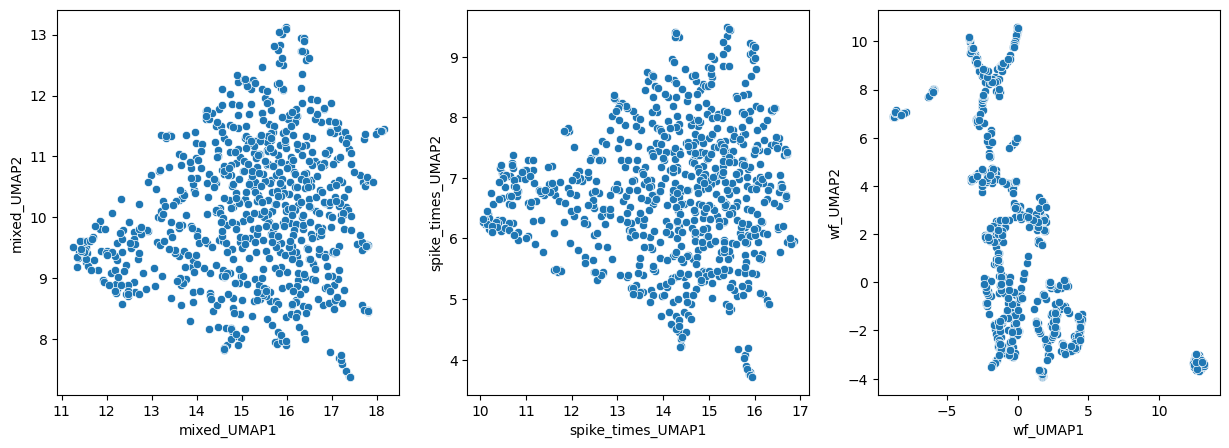

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=complete_df, x="mixed_UMAP1", y="mixed_UMAP2", ax=ax[0])
sns.scatterplot(data=complete_df, x="spike_times_UMAP1", y="spike_times_UMAP2", ax=ax[1])
sns.scatterplot(data=complete_df, x="wf_UMAP1", y="wf_UMAP2", ax=ax[2])
plt.show()

In [24]:
from summary_metrics import *

spike_trains_val = spike_trains[3500:]
spike_trains_val = spike_trains_val[0:768]
#spike_trains_val
position_val = position[3500:]
waveforms_val_new = waveforms_val[0:768]
position_val = position_val[0:768]
firing_rates = [firing_rate(spike_train) for spike_train in spike_trains_val]
print(len(firing_rates))
isi_metricas = [isi_metrics(spike_train) for spike_train in spike_trains_val]
cv2_metrics = [cv2_filter(spike_train) for spike_train in spike_trains_val]
mean_isi = [isi["mean"] for isi in isi_metricas]
std_isi = [isi["std"] for isi in isi_metricas]
cv_isi = [isi["cv"] for isi in isi_metricas]
min_isi = [isi["min"] for isi in isi_metricas]
mode_isi = [isi["mode"] for isi in isi_metricas]
max_isi = [isi["max"] for isi in isi_metricas]
waveform_width_half = [waveform_width_half_height(waveform) for waveform in waveforms_val_new]
waveform_spike_amplitude = [spike_amplitude(waveform) for waveform in waveforms_val_new]


complete_df["firing_rate"] = firing_rates
complete_df["mean_isi"] = mean_isi
complete_df["std_isi"] = std_isi
complete_df["cv_isi"] = cv_isi
complete_df["min_isi"] = min_isi
complete_df["mode_isi"] = mode_isi
complete_df["max_isi"] = max_isi
complete_df["cv2_metrics"] = cv2_metrics
complete_df["waveform_width_half"] = waveform_width_half
complete_df["waveform_spike_amplitude"] = waveform_spike_amplitude
complete_df["position"] = position_val
complete_df

768


,mixed_UMAP1,mixed_UMAP2,spike_times_UMAP1,spike_times_UMAP2,wf_UMAP1,wf_UMAP2,firing_rate,mean_isi,std_isi,cv_isi,min_isi,mode_isi,max_isi,cv2_metrics,waveform_width_half,waveform_spike_amplitude,position
0,16.652172,10.106909,15.786892,6.193446,-0.451307,3.867401,1.835026,0.545447,0.286891,0.525974,0.02010,0.89170,3.88535,0.006610,4,99.200436,"[2117.5, 910.0]"
1,15.406885,11.040698,15.154669,6.942494,3.429198,-0.041134,4.848881,0.206304,0.244856,1.186870,0.00070,0.01680,3.82920,0.002415,9,49.433144,"[2047.5, 822.5]"
2,15.848670,11.189031,15.445297,7.425246,2.676056,-2.028503,0.205182,4.917247,4.682276,0.952215,0.07625,2.34205,21.51470,0.022309,7,37.712348,"[1085.0, 420.0]"
3,16.565037,8.991047,14.651653,5.655382,0.309367,-0.662935,0.392883,2.557071,2.881782,1.126986,0.00595,1.08435,22.68265,0.011765,4,42.371664,"[1085.0, 420.0]"
4,13.977190,10.971107,13.707028,6.019604,2.502616,-1.487848,0.198787,5.073154,5.054248,0.996273,0.08225,10.92390,22.38155,0.048094,6,45.140863,"[2520.0, 805.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,17.104130,10.263214,16.602238,6.849992,3.200553,-2.607731,3.201127,0.312564,0.352811,1.128763,0.00180,0.01675,4.54880,0.001524,5,40.141254,"[2677.5, 1295.0]"
764,14.937160,11.848809,15.621835,8.325210,1.889103,-0.532128,0.135831,7.464331,6.185838,0.828720,0.08625,13.86085,24.28800,0.035017,5,47.379159,"[2677.5, 1295.0]"
765,16.691822,8.662700,15.463462,5.198104,4.259271,-1.419836,7.747043,0.129109,0.138361,1.071657,0.00055,0.01665,1.44750,0.001406,6,31.264817,"[2187.5, 892.5]"
766,14.559239,11.839553,14.559877,8.000992,3.497074,-1.148941,2.687409,0.372338,0.416379,1.118282,0.00185,0.28600,5.21150,0.003272,8,41.256657,"[1242.5, 910.0]"


In [ ]:
#Remove warnings
import warnings
warnings.filterwarnings('ignore')

columns = ["firing_rate", "mean_isi", "std_isi", "cv_isi", "min_isi", "mode_isi", "max_isi", "cv2_metrics", "waveform_width_half", "waveform_spike_amplitude"]
# for i, column in enumerate(columns):
#     fig, ax = plt.subplots(1, 3, figsize=(15, 6))
#     sns.scatterplot(data=complete_df, x="mixed_UMAP1", y="mixed_UMAP2", hue=column, ax=ax[0])
#     sns.scatterplot(data=complete_df, x="spike_times_UMAP1", y="spike_times_UMAP2", hue=column, ax=ax[1])
#     sns.scatterplot(data=complete_df, x="wf_UMAP1", y="wf_UMAP2", hue=column, ax=ax[2])
#     plt.show()

/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packa

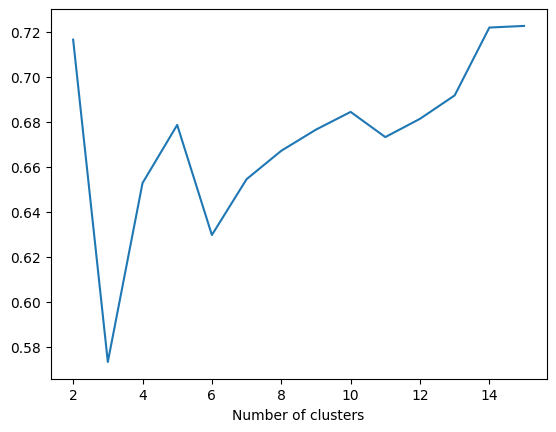

In [32]:
#Cluster based on eucledian distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

complete_df['X'] = complete_df['position'].apply(lambda x: x[0])
complete_df['Y'] = complete_df['position'].apply(lambda x: x[1])
#Use complete_df['X'] and complete_df['Y] as the x and y coordinates to measure the distance
X = complete_df[['X', 'Y']]
#Find the best number of clusters based on silhouette_score
silhouette_scores = []
for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
plt.plot(range(2, 16), silhouette_scores)
plt.xlabel('Number of clusters')

#The best one was 6.
#Let's get the labels
kmeans = KMeans(n_clusters=6, random_state=42)
complete_df['cluster'] = kmeans.fit_predict(X)

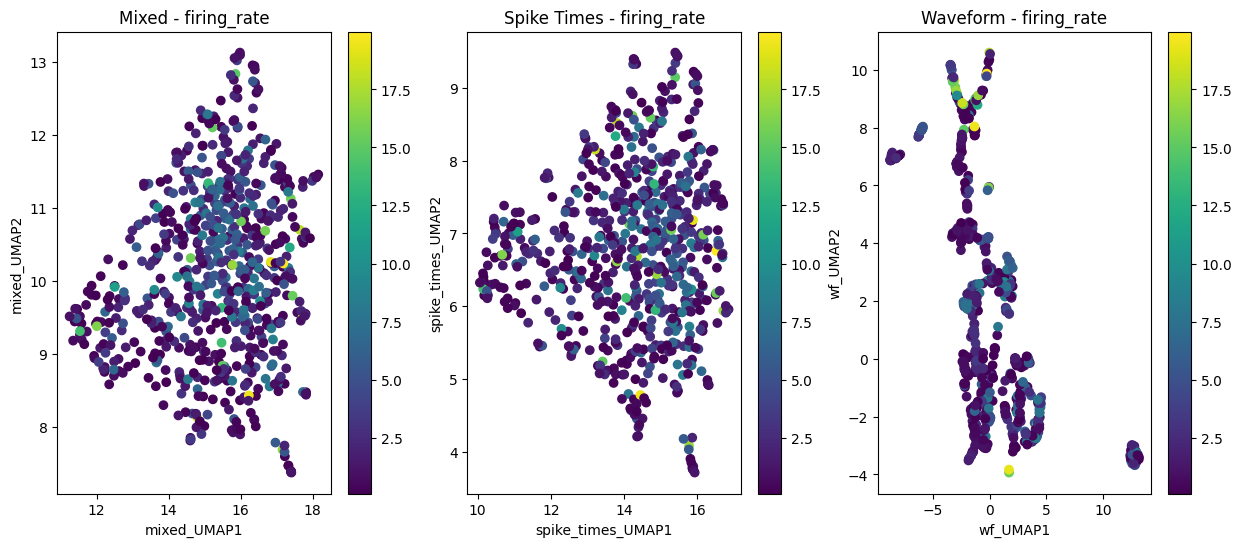

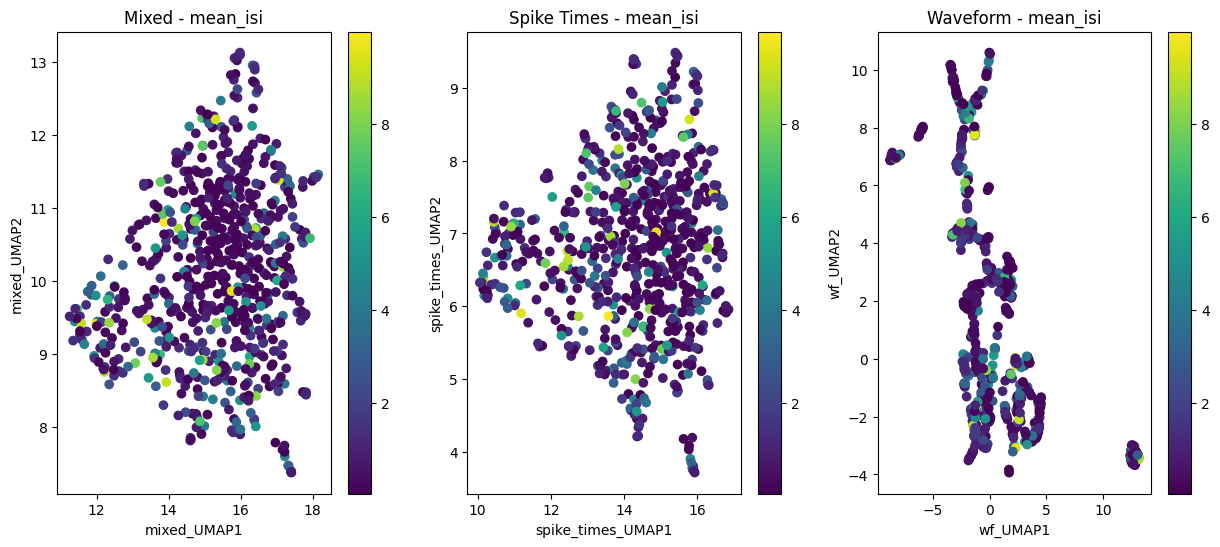

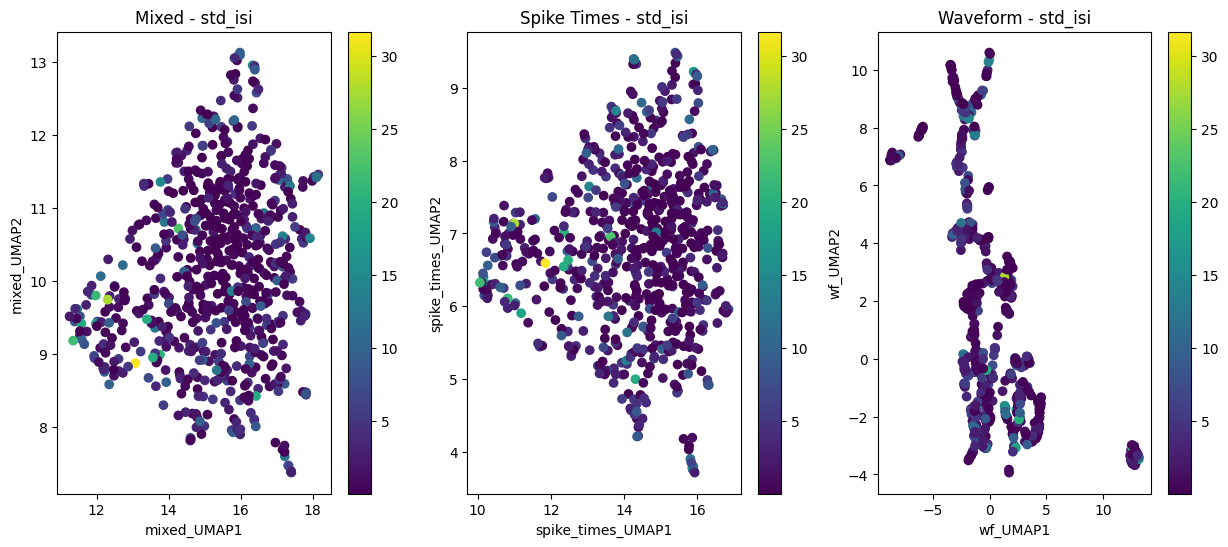

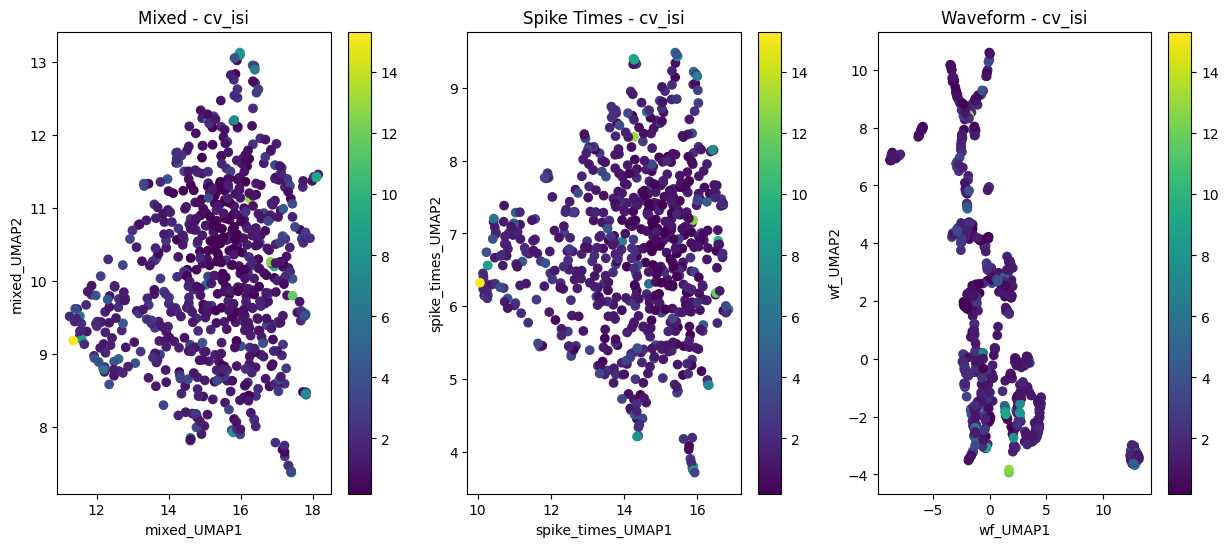

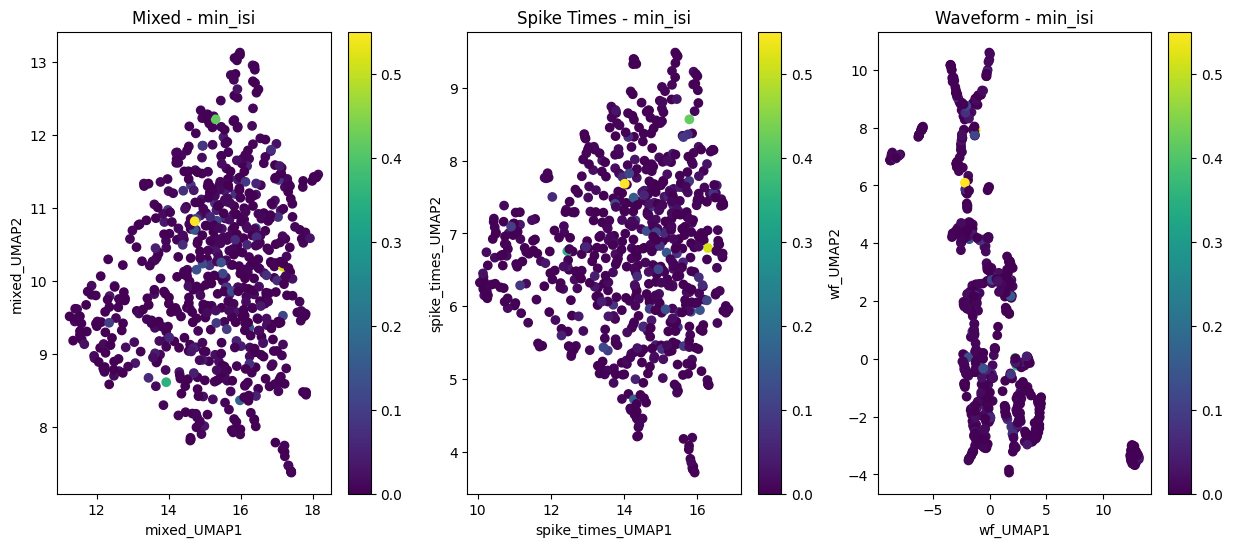

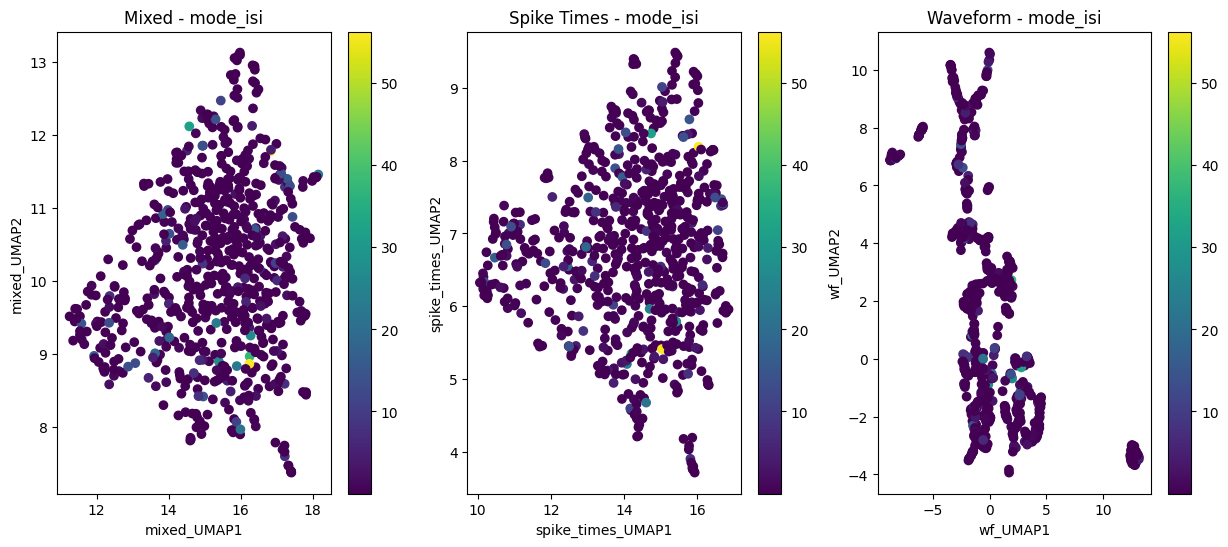

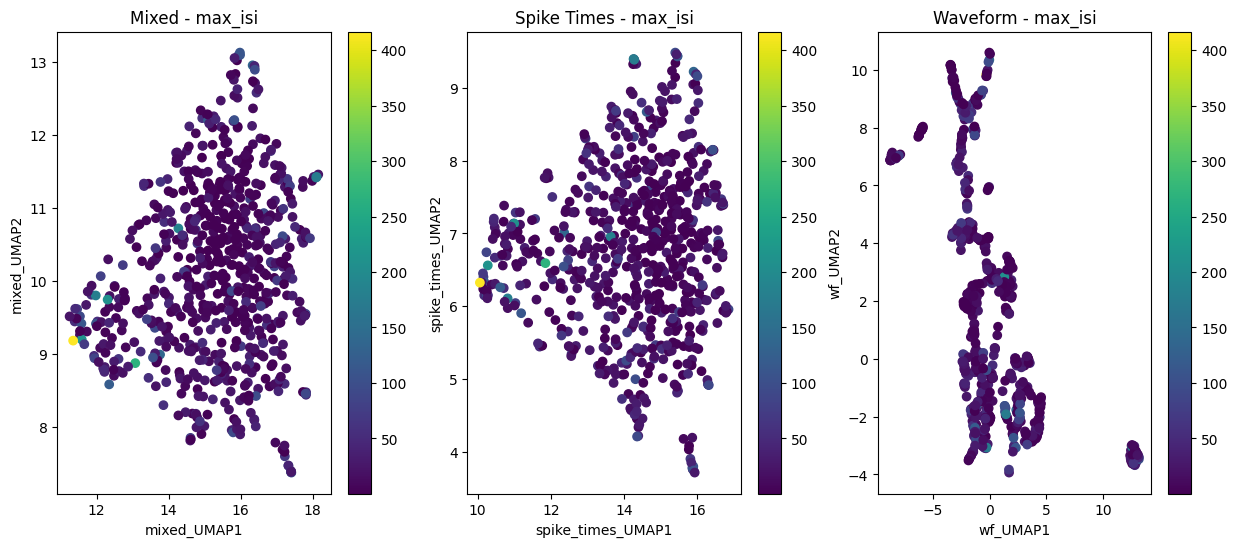

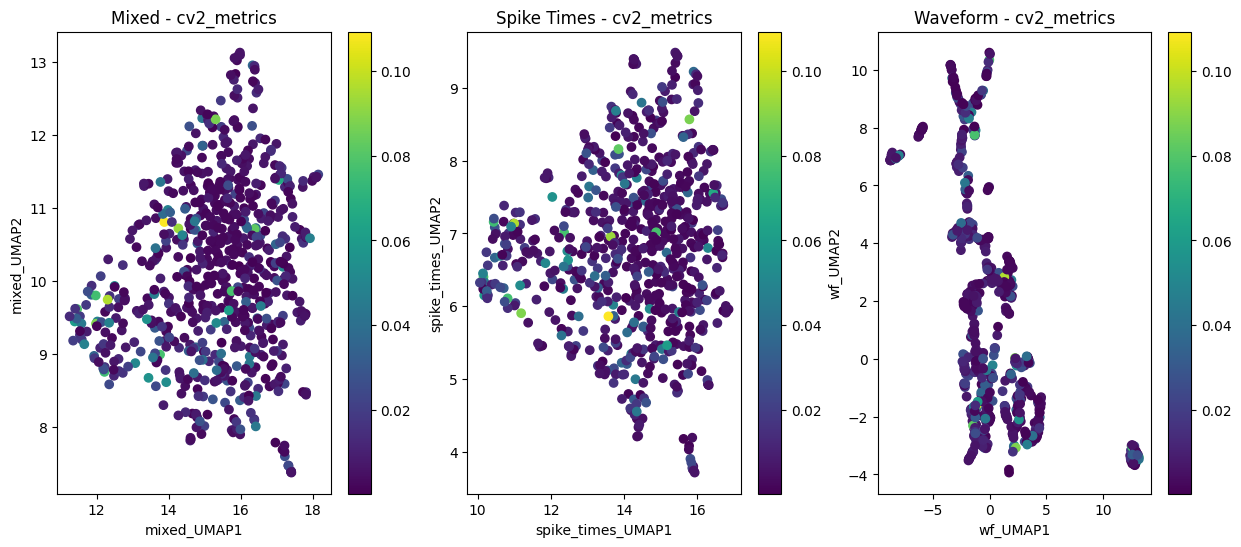

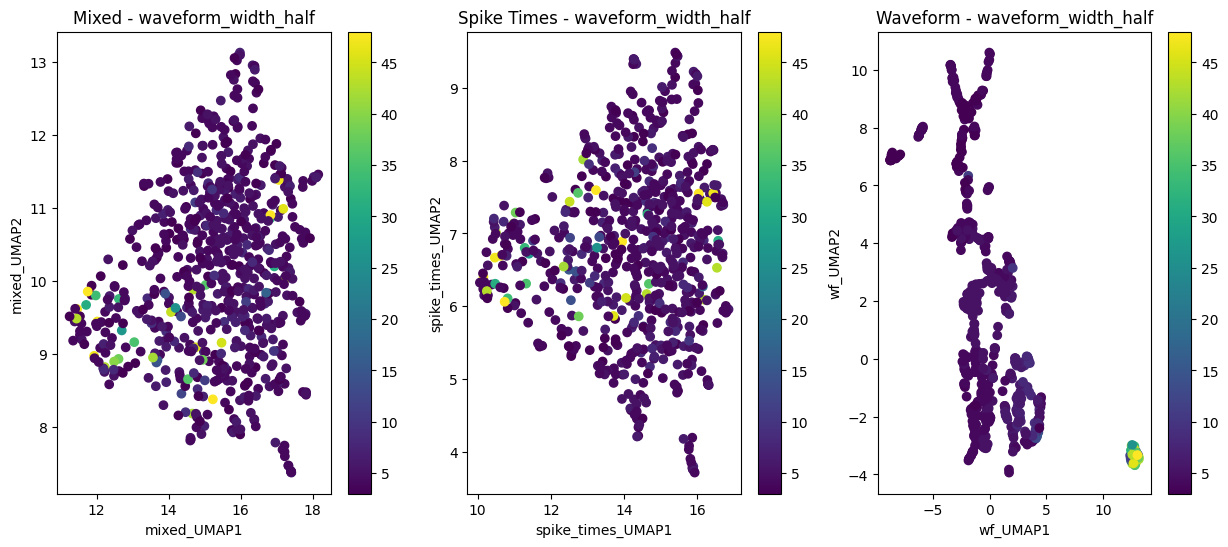

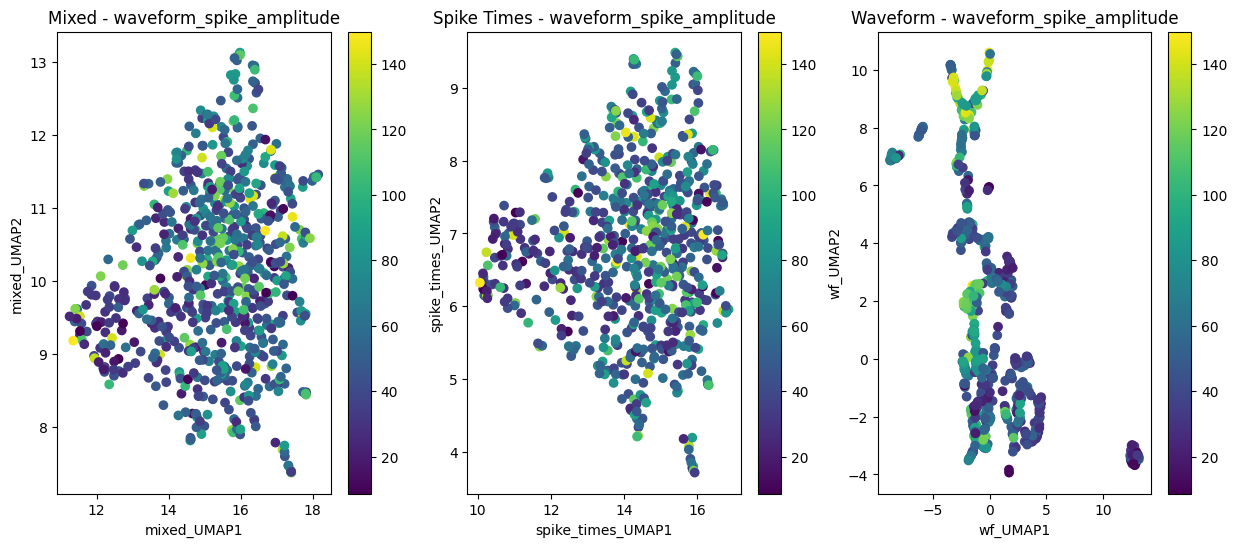

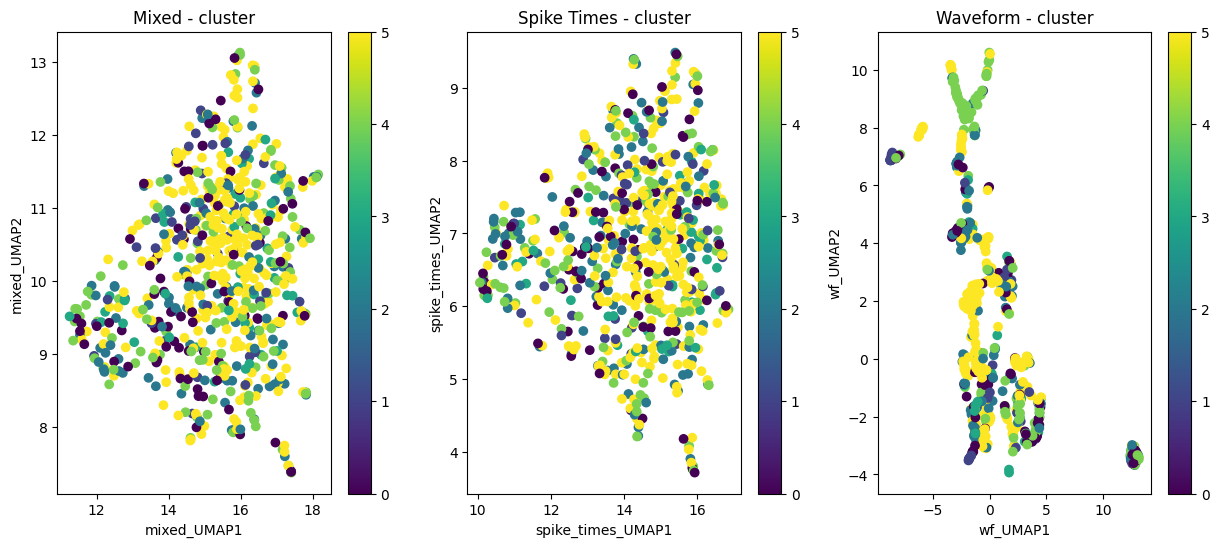

In [34]:
import matplotlib.pyplot as plt

columns = ["firing_rate", "mean_isi", "std_isi", "cv_isi", "min_isi", "mode_isi", "max_isi", "cv2_metrics", "waveform_width_half", "waveform_spike_amplitude","cluster"]

#Remove outliers from completedf
complete_df1 = complete_df[complete_df["firing_rate"] < 20]
complete_df1 = complete_df1[complete_df1["waveform_spike_amplitude"] < 150]


for i, column in enumerate(columns):
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    scatter1 = ax[0].scatter(complete_df1["mixed_UMAP1"], complete_df1["mixed_UMAP2"], c=complete_df1[column])
    scatter2 = ax[1].scatter(complete_df1["spike_times_UMAP1"], complete_df1["spike_times_UMAP2"], c=complete_df1[column])
    scatter3 = ax[2].scatter(complete_df1["wf_UMAP1"], complete_df1["wf_UMAP2"], c=complete_df1[column])
    
    # Add colorbar
    cbar1 = fig.colorbar(scatter1, ax=ax[0])
    cbar2 = fig.colorbar(scatter2, ax=ax[1])
    cbar3 = fig.colorbar(scatter3, ax=ax[2])
    
    #Plot the column as title for the three subplots on top


    # Set x and y axis labels
    
    ax[0].set_title(f"Mixed - {column}")
    ax[1].set_title(f"Spike Times - {column}")
    ax[2].set_title(f"Waveform - {column}")

    ax[0].set_xlabel("mixed_UMAP1")
    ax[0].set_ylabel("mixed_UMAP2")

    ax[1].set_xlabel("spike_times_UMAP1")
    ax[1].set_ylabel("spike_times_UMAP2")

    ax[2].set_xlabel("wf_UMAP1")
    ax[2].set_ylabel("wf_UMAP2")
    
    plt.show()

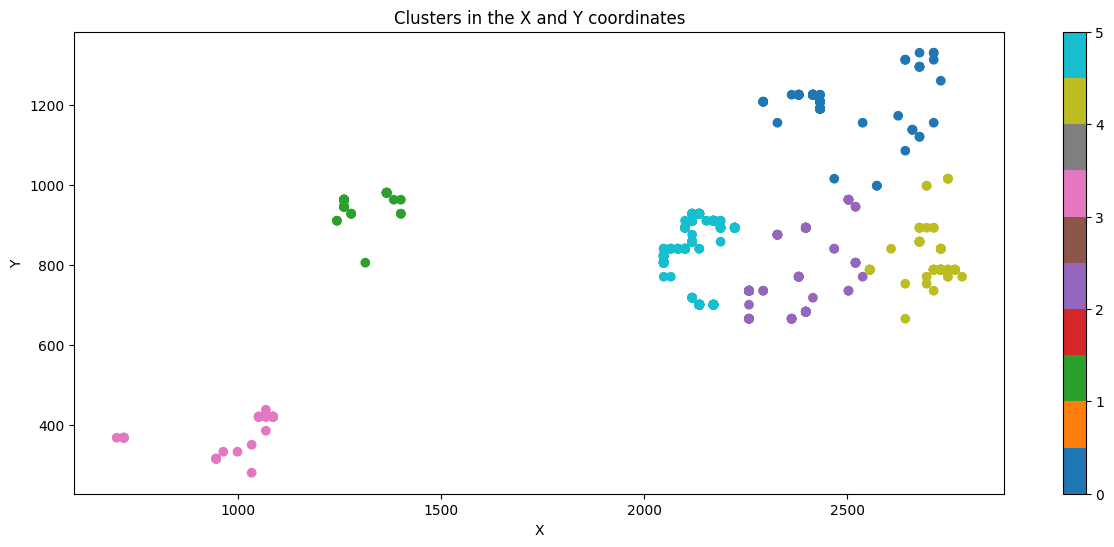

In [36]:
#Plot the clusters in the X and Y coordinates
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
scatter = ax.scatter(complete_df1['X'], complete_df1['Y'], c=complete_df1['cluster'], cmap='tab10')
cbar = fig.colorbar(scatter, ax=ax)
ax.set_title("Clusters in the X and Y coordinates")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()


In [37]:
complete_df.to_csv("Test_Multimodal.csv")